In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
df=pd.read_csv('cleaned_data.csv',index_col=0)
df.head()

,airline,rating,nationality,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Inflight Entertainment,Wifi & Connectivity,Recommended,trip_verified,review,flight_type,standardized_departure,standardized_arrival,Month,Year
0,ab-aviation,9,Netherlands,Solo Leisure,Economy Class,4.0,5.0,4.0,4.0,3.0,NaN,NaN,yes,1,pretty decent airline Moroni to Moheli. Turne...,Direct,Moroni,Moheli,November,2019.0
1,ab-aviation,1,United Kingdom,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,2.0,NaN,NaN,no,1,Not a good airline Moroni to Anjouan. It is a ...,Direct,Moroni,Anjouan,June,2019.0
2,ab-aviation,1,United Kingdom,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,2.0,NaN,NaN,no,1,flight was fortunately short Anjouan to Dzaou...,Direct,Anjouan,Dzaoudzi,June,2019.0
3,adria-airways,1,Serbia,Solo Leisure,Economy Class,1.0,1.0,NaN,1.0,1.0,NaN,NaN,no,0,I will never fly again with Adria Please do a...,Direct,Frankfurt,Pristina,September,2019.0
4,adria-airways,1,Netherlands,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no,1,it ruined our last days of holidays Do not boo...,Transit,Sofia,Amsterdam,September,2019.0


In [4]:
df.shape

(131906, 20)

In [5]:
df['review'].apply(lambda x:len(str(x).split())).max()

1064

In [6]:
df['Recommended'].unique()

array(['yes', 'no'], dtype=object)

In [7]:
df['Recommended'].value_counts()

Recommended
no     80764
yes    51142
Name: count, dtype: int64

In [8]:
df['target']=df['Recommended'].map({'no':0,'yes':1})

In [9]:
df['target'].value_counts()

target
0    80764
1    51142
Name: count, dtype: int64

In [10]:
lemmatizer = WordNetLemmatizer()
def text_preprocessor(text):
    text=re.sub(r'http[s]?://\S+', '', text)
    text=re.sub(r'@\w+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'\d+','',text)
    tokens = word_tokenize(text)
    tokens=[word.lower() for word in tokens]

    stop_words = set(stopwords.words('english'))
    filted_tokens=[word for word in tokens if word not in stop_words]

    lemmatized_tokens=[lemmatizer.lemmatize(token) for token in filted_tokens]
    preprocessed_text=' '.join(lemmatized_tokens)
    return preprocessed_text

In [11]:
df['processed_text']=df['review'].apply(text_preprocessor)

In [12]:
X=df['processed_text']
y=df['target']
X_train,X_valid,y_train,y_valid=train_test_split(X,y,random_state=42,
                                                 test_size=0.2,shuffle=True)

In [13]:
combined_vectorizer=FeatureUnion([('tfidf',TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', ngram_range=(1,3), use_idf=True, sublinear_tf=True, smooth_idf=True, stop_words='english')),('CountVectorizer',CountVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', ngram_range=(1,3), stop_words='english'))])

In [14]:
classifier={'Naive Bayes':MultinomialNB(),
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier()
}

vectorizer = {
    'tfidf': TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', ngram_range=(1,3), use_idf=True, sublinear_tf=True, smooth_idf=True, stop_words='english'),
    'CountVectorizer': CountVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', ngram_range=(1,3), stop_words='english'),
    'Combined': combined_vectorizer
}

MLresult=[]
for vec_name, vec in vectorizer.items():
    for clf_name,clf in classifier.items():
        pipe=Pipeline([
            (vec_name,vec),
            (clf_name,clf)
        ])
        pipe.fit(X_train,y_train)
        pred=pipe.predict(X_valid)
        accuracy=accuracy_score(y_valid,pred)
        MLresult.append({
            'Classifier': clf_name,
            'Vectorizer': vec_name,
            'Accuracy':accuracy
        })
MLresult=pd.DataFrame(MLresult)
MLresult

,Classifier,Vectorizer,Accuracy
0,Naive Bayes,tfidf,0.885452
1,Logistic Regression,tfidf,0.921954
2,Random Forest,tfidf,0.894284
3,Naive Bayes,CountVectorizer,0.869911
4,Logistic Regression,CountVectorizer,0.923357
5,Random Forest,CountVectorizer,0.891896
6,Naive Bayes,Combined,0.873323
7,Logistic Regression,Combined,0.923357
8,Random Forest,Combined,0.894360


In [ ]:
#use keras tokenizer
token=text.Tokenizer(num_words=None)
max_len=1100

token.fit_on_texts(list(X_train)+list(X_valid))
X_train_seq=token.texts_to_sequences(X_train)
X_valid_seq=token.texts_to_sequences(X_valid)

#zero pad the seq
X_train_pad=sequence.pad_sequences(X_train_seq,maxlen=max_len)
X_valid_pad=sequence.pad_sequences(X_valid_seq,maxlen=max_len)

word_index=token.word_index

In [ ]:

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:

%%time
with strategy.scope():
  #simple RNN without any pretrained embeddings and one dense 1 layer
  model=Sequential()
  model.add(Embedding(len(word_index)+1,
                      300,
                      input_length=max_len))
  model.add(SimpleRNN(100))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1100, 300)         28745100  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 28785301 (109.81 MB)
Trainable params: 28785301 (109.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: user 602 ms, sys: 488 ms, total: 1.09 s
Wall time: 794 ms


In [ ]:
model.fit(X_train_pad,y_train,epochs=2,batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/2
1649/1649 [==============================] - 3506s 2s/step - loss: 0.5568 - accuracy: 0.7099
Epoch 2/2
1649/1649 [==============================] - 3463s 2s/step - loss: 0.4635 - accuracy: 0.7855


In [ ]:
pred=model.predict(X_valid_pad)
print('auccuracy:{:.2f}%'.format(roc_auc(pred,y_valid)*100))

825/825 [==============================] - 111s 135ms/step
auccuracy:81.02%


RNN is to input the sentence word by word. So without the attention mechanism, the simple RNN model will not perform better than the traditional NLP model.

In [ ]:
scores_model=[]
scores_model.append({'Model':'SimpleRNN','Auccuracy':roc_auc(pred,y_valid)})

In [ ]:
#use keras tokenizer
max_words=5100
token=text.Tokenizer(num_words=max_words)
max_len=1100

token.fit_on_texts(list(X_train)+list(X_valid))
X_train_seq=token.texts_to_sequences(X_train)
X_valid_seq=token.texts_to_sequences(X_valid)

#zero pad the seq
X_train_pad=sequence.pad_sequences(X_train_seq,maxlen=max_len)
X_valid_pad=sequence.pad_sequences(X_valid_seq,maxlen=max_len)

In [ ]:
#LSTM
from keras.layers import Input
from keras.models import Model
from keras.optimizers import RMSprop
def RNN():
  inputs=Input(name='inputs',shape=[max_len])
  layer=Embedding(max_words,50,input_length=max_len)(inputs)
  layer=LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
LSTM_model=RNN()
LSTM_model.summary()
LSTM_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1100)]            0         
                                                                 
 embedding_8 (Embedding)     (None, 1100, 50)          255000    
                                                                 
 lstm_7 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_14 (Activation)  (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
LSTM_model.fit(X_train_pad,y_train,epochs=2,batch_size=64*strategy.num_replicas_in_sync)

1649/1649 [==============================] - 1606s 948ms/step - loss: 0.2671 - accuracy: 0.8970
Epoch 2/2
1649/1649 [==============================] - 1540s 934ms/step - loss: 0.2109 - accuracy: 0.9246


In [ ]:
pred=LSTM_model.predict(X_valid_pad)
print('auccuracy:{:.2f}%'.format(roc_auc(pred,y_valid)*100))

825/825 [==============================] - 147s 178ms/step
auccuracy:97.29%


In [ ]:
scores_model.append({
    'Model':'LSTM',
    'Accuracy':roc_auc(pred,y_valid)
})

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))

In [ ]:
#Bi-Directional RNN
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    BR_model = Sequential()
    BR_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    BR_model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    BR_model.add(Dense(1,activation='sigmoid'))
    BR_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


BR_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1100, 300)         28745100  
                                                                 
 bidirectional (Bidirection  (None, 600)               1442400   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 601       
                                                                 
Total params: 30188101 (115.16 MB)
Trainable params: 1443001 (5.50 MB)
Non-trainable params: 28745100 (109.65 MB)
_________________________________________________________________
CPU times: user 909 ms, sys: 828 ms, total: 1.74 s
Wall time: 875 ms


In [ ]:
BR_model.fit(X_train_pad, y_train, epochs=2, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/2
1649/1649 [==============================] - 10825s 7s/step - loss: 0.6684 - accuracy: 0.6124
Epoch 2/2
1649/1649 [==============================] - 10761s 7s/step - loss: 0.6682 - accuracy: 0.6124


In [ ]:
pred=BR_model.predict(X_valid_pad)
print('auccuracy:{:.2f}%'.format(roc_auc(pred,y_valid)*100))

825/825 [==============================] - 970s 1s/step
auccuracy:50.00%


In [ ]:
from keras.utils import to_categorical
from keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import layers
from keras import Model

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 50
heads = 2
neurons = 32
maxlen = 1100
vocab_size = 50000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
token=text.Tokenizer(num_words=vocab_size)
max_len=1100

token.fit_on_texts(list(X_train)+list(X_valid))
X_train_seq=token.texts_to_sequences(X_train)
X_valid_seq=token.texts_to_sequences(X_valid)

#zero pad the seq
X_train_pad=sequence.pad_sequences(X_train_seq,maxlen=max_len)
X_valid_pad=sequence.pad_sequences(X_valid_seq,maxlen=max_len)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1100)]            0         
                                                                 
 token_and_position_embeddi  (None, 1100, 50)          2555000   
 ng_3 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_encoder_3 (Tra  (None, 1100, 50)          23832     
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_3  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_11 (Dropout)        (None, 50)                0   

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = model.fit(X_train_pad,y_train,
                    validation_data=(X_valid_pad,y_valid),
                    epochs=5,
                    batch_size=64*strategy.num_replicas_in_sync,
                    callbacks=[earlystopping])

Epoch 1/5
1649/1649 [==============================] - 2277s 1s/step - loss: 0.3350 - accuracy: 0.8429 - val_loss: 0.2080 - val_accuracy: 0.9205
Epoch 2/5
1649/1649 [==============================] - 2262s 1s/step - loss: 0.1963 - accuracy: 0.9275 - val_loss: 0.2128 - val_accuracy: 0.9246
Epoch 2: early stopping


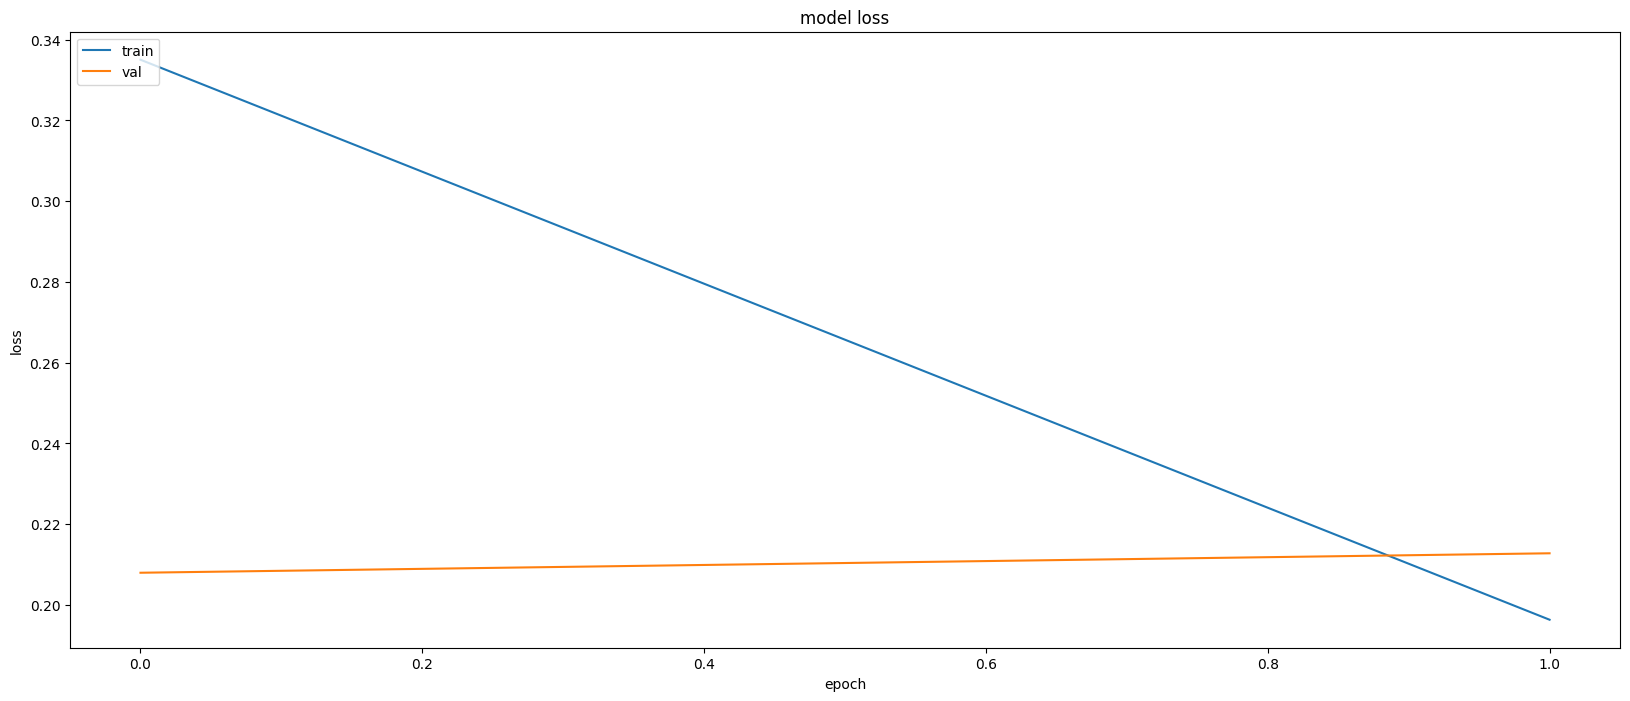

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

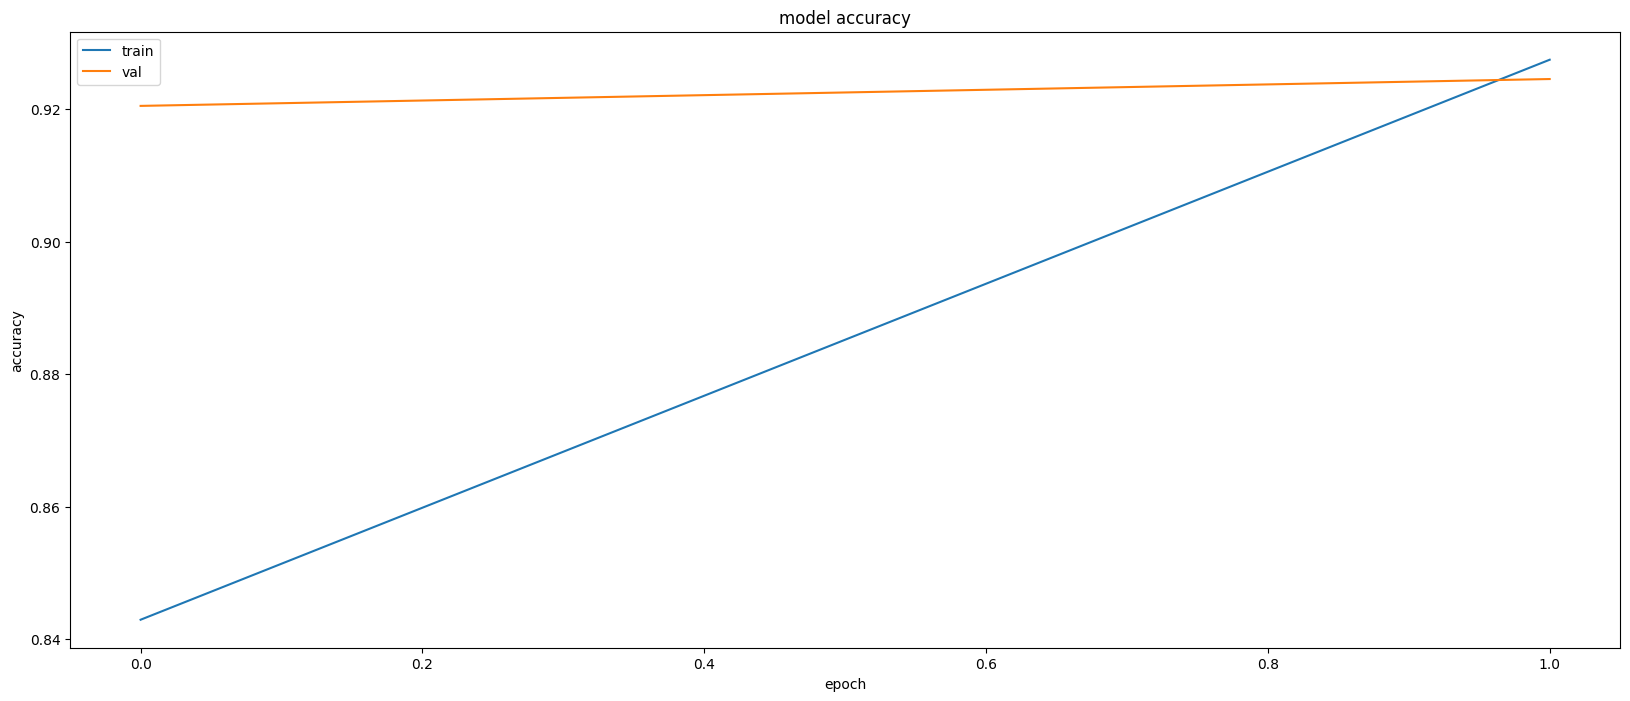

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred=model.predict(X_valid_pad)
print('auccuracy:{:.2f}%'.format(roc_auc(pred,y_valid)*100))

825/825 [==============================] - 262s 317ms/step
auccuracy:97.43%


In [ ]:
model_performance={
    'Model':['Simple RNN','LSTM','BiDirectional RNN','Transformer'],
    'Accuracy':[0.8102,0.9729,0.5000,0.9743]
}

In [ ]:
model_performance_df=pd.DataFrame(model_performance)
model_performance_df

,Model,Accuracy
0,Simple RNN,0.8102
1,LSTM,0.9729
2,BiDirectional RNN,0.5000
3,Transformer,0.9743
